In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data_path = '/content/drive/MyDrive/Cardiomegaly/train/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [4]:
test_data_path = '/content/drive/MyDrive/Cardiomegaly/test/test'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [5]:
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=42)

In [6]:
img_size = (224,224)
batch_size = 16


tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4448 validated image filenames belonging to 2 classes.
Found 567 validated image filenames belonging to 2 classes.
Found 567 validated image filenames belonging to 2 classes.


In [7]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

# plt.figure(figsize= (20,20))

# for i in range(16):
#     plt.subplot(4,4,i+1)
#     image = images[i] / 255
#     plt.imshow(image)
#     index = np.argmax(labels[i])
#     class_name = classes[index]
#     plt.title(class_name , color = 'blue' , fontsize= 12)
#     plt.axis('off')
# plt.show();

In [8]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Add, Activation
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import os

# Clear any previous session
tf.keras.backend.clear_session()

# Define the classes (ensure that gen_dict is defined somewhere in your code)
classes = list(gen_dict.keys())
num_class = len(classes)

# Residual Block function
def residual_block(x, units):
    residual = x
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(units)(x)
    x = Add()([x, residual])
    x = Activation('relu')(x)
    return x

# Function to create the EfficientNetB7-based model with residual blocks
def get_efficientnet_b7_pretrained_with_residuals():
    inputs = Input(shape=(224, 224, 3))
    base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)(inputs)
    # Apply Global Average Pooling to reduce the spatial dimensions
    x = GlobalAveragePooling2D()(base_model)
    x = Dropout(0.5)(x)

    # Dense Layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.016))(x)
    x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.016),
              activity_regularizer=l1(0.006), bias_regularizer=l1(0.006))(x)
    x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
    x = Dropout(0.3)(x)

    # Adding Residual Blocks
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    # Additional Dense Layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_class, activation='softmax')(x)

    model = Model(inputs, outputs)

    loss = tf.keras.losses.CategoricalCrossentropy()
    adamax = Adamax(learning_rate=0.001)
    model.compile(loss=loss, optimizer=adamax, metrics=['accuracy'])
    return model

# Instantiate the model
model = get_efficientnet_b7_pretrained_with_residuals()
model.summary()

# Callbacks for learning rate reduction and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Load the model from disk
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/Cardiomegaly/efficientnet.weights.h5')
except:
    print("Model loading failed. Trying a different method")
    model = get_efficientnet_b7_pretrained_with_residuals()
    model.load_weights('/content/drive/MyDrive/Cardiomegaly/efficientnet.weights.h5')

print("Model was successfully loaded")


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb7            │ (None, 7, 7, 2560)     │     64,097,687 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2560)           │              0 │ efficientnetb7[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2560)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,311,232 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │         65,792 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256)            │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 65,849,817 (251.20 MB)

 Trainable params: 65,536,530 (250.00 MB)

 Non-trainable params: 313,287 (1.20 MB)

Model loading failed. Trying a different method
Model was successfully loaded


In [9]:
def unwrap_model(model):
    # Extract the EfficientNetB7 model from the original model
    efficientnet_b7 = model.get_layer('efficientnetb7')

    # Get the input and output from EfficientNetB7
    inp = efficientnet_b7.input
    out = efficientnet_b7.output

    # Manually recreate the layers after EfficientNetB7
    x = GlobalAveragePooling2D()(out)
    x = Dropout(0.5)(x)

    # Dense Layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.016))(x)
    x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.016),
              activity_regularizer=l1(0.006), bias_regularizer=l1(0.006))(x)
    x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
    x = Dropout(0.3)(x)

    # Recreate Residual Blocks
    def residual_block(x, units):
        residual = x
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(units)(x)
        x = Add()([x, residual])
        x = Activation('relu')(x)
        return x

    x = residual_block(x, 256)
    x = residual_block(x, 256)

    # Additional Dense Layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Final classification layer (modify according to number of classes)
    outputs = Dense(num_class, activation='softmax')(x)

    # Create the new model with re-applied layers
    new_model = Model(inputs=inp, outputs=outputs)

    return new_model

# Instantiate the model and unwrap it
unwrapped_model = unwrap_model(model)
unwrapped_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 65,849,817 (251.20 MB)

 Trainable params: 65,536,530 (250.00 MB)

 Non-trainable params: 313,287 (1.20 MB)

In [10]:
len(classes)

2

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: 0
Prediction probabilities: [0.506322  0.4936779]


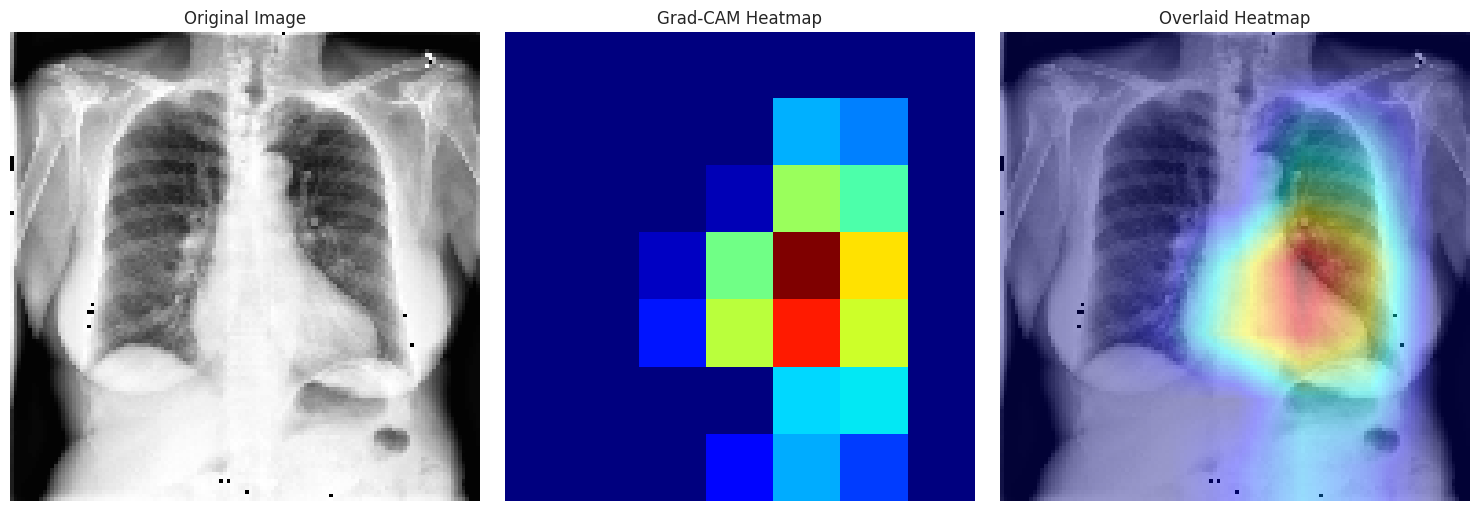

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def add_classification_head(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Assuming 'unwrapped_model' is your current model without the classification head
num_classes = 2  # Change this to match your number of classes
# model_with_head = add_classification_head(unwrapped_model, num_classes)

def get_gradcam_heatmap(img, model, class_index):
    # Use the last convolutional layer
    last_conv_layer = model.get_layer('top_conv')
    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img = np.array(img).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def overlay_heatmap(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    return superimposed_img

# Example usage
img_path = '/content/drive/MyDrive/Cardiomegaly/test/test/true/100.png'
preprocessed_img = preprocess_image(img_path)

# Get predictions
predictions = unwrapped_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Prediction probabilities: {predictions[0]}")

try:
    # Compute Grad-CAM
    heatmap = get_gradcam_heatmap(preprocessed_img, unwrapped_model, predicted_class)

    # Overlay heatmap on the original image
    superimposed_img = overlay_heatmap(heatmap, img_path)

    # Display the Grad-CAM result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img_path)[...,::-1])
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Overlaid Heatmap')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error during Grad-CAM computation: {str(e)}")
    print("Model summary:")
    unwrapped_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
Predicted class: 1
Prediction probabilities: [0.49781504 0.50218487]


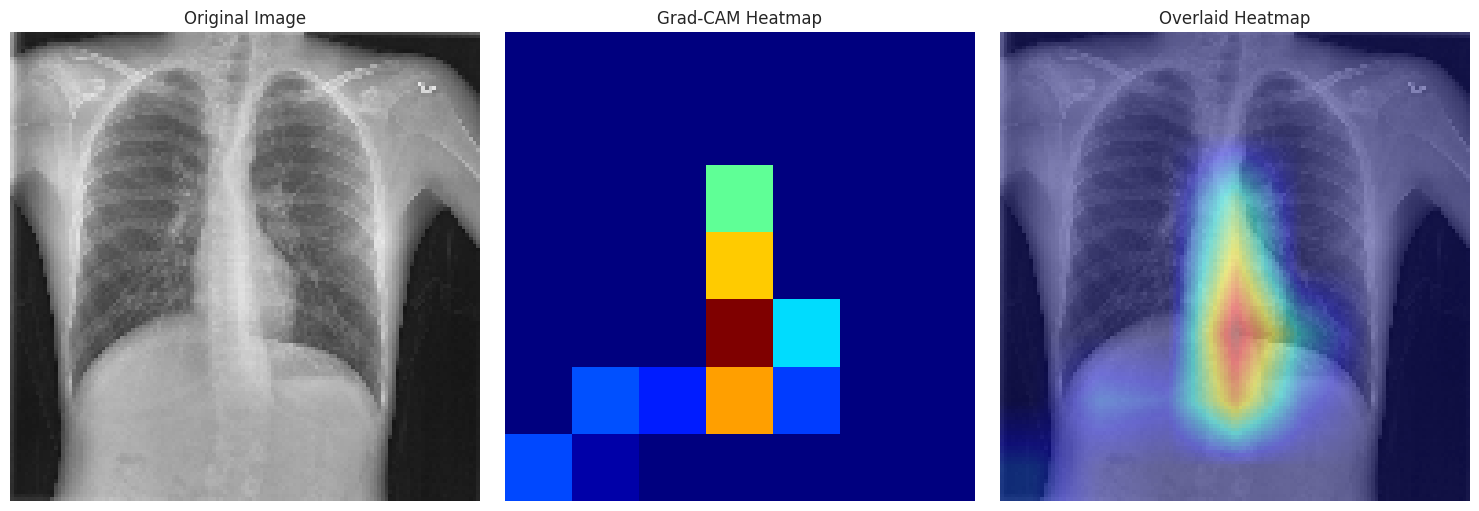

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def add_classification_head(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Assuming 'unwrapped_model' is your current model without the classification head
num_classes = 2  # Change this to match your number of classes
# model_with_head = add_classification_head(unwrapped_model, num_classes)

def get_gradcam_heatmap(img, model, class_index):
    # Use the last convolutional layer
    last_conv_layer = model.get_layer('top_conv')
    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img = np.array(img).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def overlay_heatmap(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    return superimposed_img

# Example usage
img_path = '/content/drive/MyDrive/Cardiomegaly/test/test/false/100.png'
preprocessed_img = preprocess_image(img_path)

# Get predictions
predictions = unwrapped_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Prediction probabilities: {predictions[0]}")

try:
    # Compute Grad-CAM
    heatmap = get_gradcam_heatmap(preprocessed_img, unwrapped_model, predicted_class)

    # Overlay heatmap on the original image
    superimposed_img = overlay_heatmap(heatmap, img_path)

    # Display the Grad-CAM result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(img_path)[...,::-1])
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Overlaid Heatmap')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error during Grad-CAM computation: {str(e)}")
    print("Model summary:")
    unwrapped_model.summary()